# Proyek Klasifikasi Gambar: One Piece Image Classifier
- **Nama:** Muhammad Gilang Ramadhan
- **Email:** gilangramadhanmuhammad6@gmail.com
- **ID Dicoding:** gilskuy2003

Project ini adalah klasifikasi gambar untuk pengenalan para karakter yang ada pada anime One Piece tersedia 18 label/karakter yang ada dalam dataset ini

## Import Semua Packages/Library yang Digunakan

In [44]:
import os, shutil
from tensorflow.keras.preprocessing import image
import zipfile
from pathlib import Path
from shutil import copyfile
from PIL import Image
from google.colab import files
from tqdm.notebook import tqdm as tq

In [45]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import cv2
import io
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from keras.layers import TFSMLayer

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import InputLayer, Conv2D , GlobalAveragePooling2D,MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

## Data Preparation

### Data Loading

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"geezlang","key":"f5ea1a406711faec412b33964121c41c"}'}

In [5]:
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

'/root/.kaggle/kaggle.json'

In [6]:
os.chmod("/root/.kaggle/kaggle.json", 600)

In [7]:
!kaggle datasets download -d ibrahimserouis99/one-piece-image-classifier

Dataset URL: https://www.kaggle.com/datasets/ibrahimserouis99/one-piece-image-classifier
License(s): GPL-2.0


In [8]:
!unzip one-piece-image-classifier.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Data/Data/Mihawk/201.png  
  inflating: Data/Data/Mihawk/201.png_inverted.png  
  inflating: Data/Data/Mihawk/202.png  
  inflating: Data/Data/Mihawk/202.png_inverted.png  
  inflating: Data/Data/Mihawk/203.png  
  inflating: Data/Data/Mihawk/203.png_inverted.png  
  inflating: Data/Data/Mihawk/204.png  
  inflating: Data/Data/Mihawk/204.png_inverted.png  
  inflating: Data/Data/Mihawk/205.png  
  inflating: Data/Data/Mihawk/205.png_inverted.png  
  inflating: Data/Data/Mihawk/206.png  
  inflating: Data/Data/Mihawk/206.png_inverted.png  
  inflating: Data/Data/Mihawk/207.png  
  inflating: Data/Data/Mihawk/207.png_inverted.png  
  inflating: Data/Data/Mihawk/208.png  
  inflating: Data/Data/Mihawk/208.png_inverted.png  
  inflating: Data/Data/Mihawk/209.png  
  inflating: Data/Data/Mihawk/209.png_inverted.png  
  inflating: Data/Data/Mihawk/21.png  
  inflating: Data/Data/Mihawk/21.png_inverted.png  
  inflating: 

In [9]:
dataset_path = "/content/Data/Data"

image_sizes = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                image_sizes.append(img.size)

for i, size in enumerate(image_sizes[:10]):
    print(f"Gambar ke-{i+1}: {size}")

size_distribution = Counter(image_sizes)
print("\nDistribusi ukuran gambar:")
for size, count in size_distribution.items():
    print(f"{size}: {count} gambar")

print(f"\nTotal jumlah gambar dalam dataset: {len(image_sizes)}")

Gambar ke-1: (316, 359)
Gambar ke-2: (369, 347)
Gambar ke-3: (404, 404)
Gambar ke-4: (364, 219)
Gambar ke-5: (210, 351)
Gambar ke-6: (189, 301)
Gambar ke-7: (389, 295)
Gambar ke-8: (400, 400)
Gambar ke-9: (227, 195)
Gambar ke-10: (372, 221)

Distribusi ukuran gambar:
(316, 359): 1 gambar
(369, 347): 1 gambar
(404, 404): 6 gambar
(364, 219): 1 gambar
(210, 351): 1 gambar
(189, 301): 1 gambar
(389, 295): 1 gambar
(400, 400): 278 gambar
(227, 195): 1 gambar
(372, 221): 1 gambar
(350, 384): 1 gambar
(184, 398): 1 gambar
(392, 368): 1 gambar
(198, 148): 1 gambar
(337, 219): 1 gambar
(226, 220): 1 gambar
(306, 266): 1 gambar
(400, 205): 4 gambar
(381, 296): 1 gambar
(400, 232): 1 gambar
(215, 390): 1 gambar
(230, 366): 1 gambar
(339, 185): 1 gambar
(330, 219): 1 gambar
(398, 182): 1 gambar
(400, 238): 2 gambar
(166, 192): 1 gambar
(193, 239): 1 gambar
(400, 206): 3 gambar
(400, 240): 1 gambar
(260, 397): 1 gambar
(399, 218): 1 gambar
(293, 220): 1 gambar
(400, 305): 1 gambar
(365, 218): 1 ga



*   Output yang dihasilkan pada cell diatas menunjukkan bahwa dataset ini memiliki keragaman ukuran pada gambar yang ada dan total gambar yang tersedia dalam dataset ini adalah 11737



### Data Preprocessing

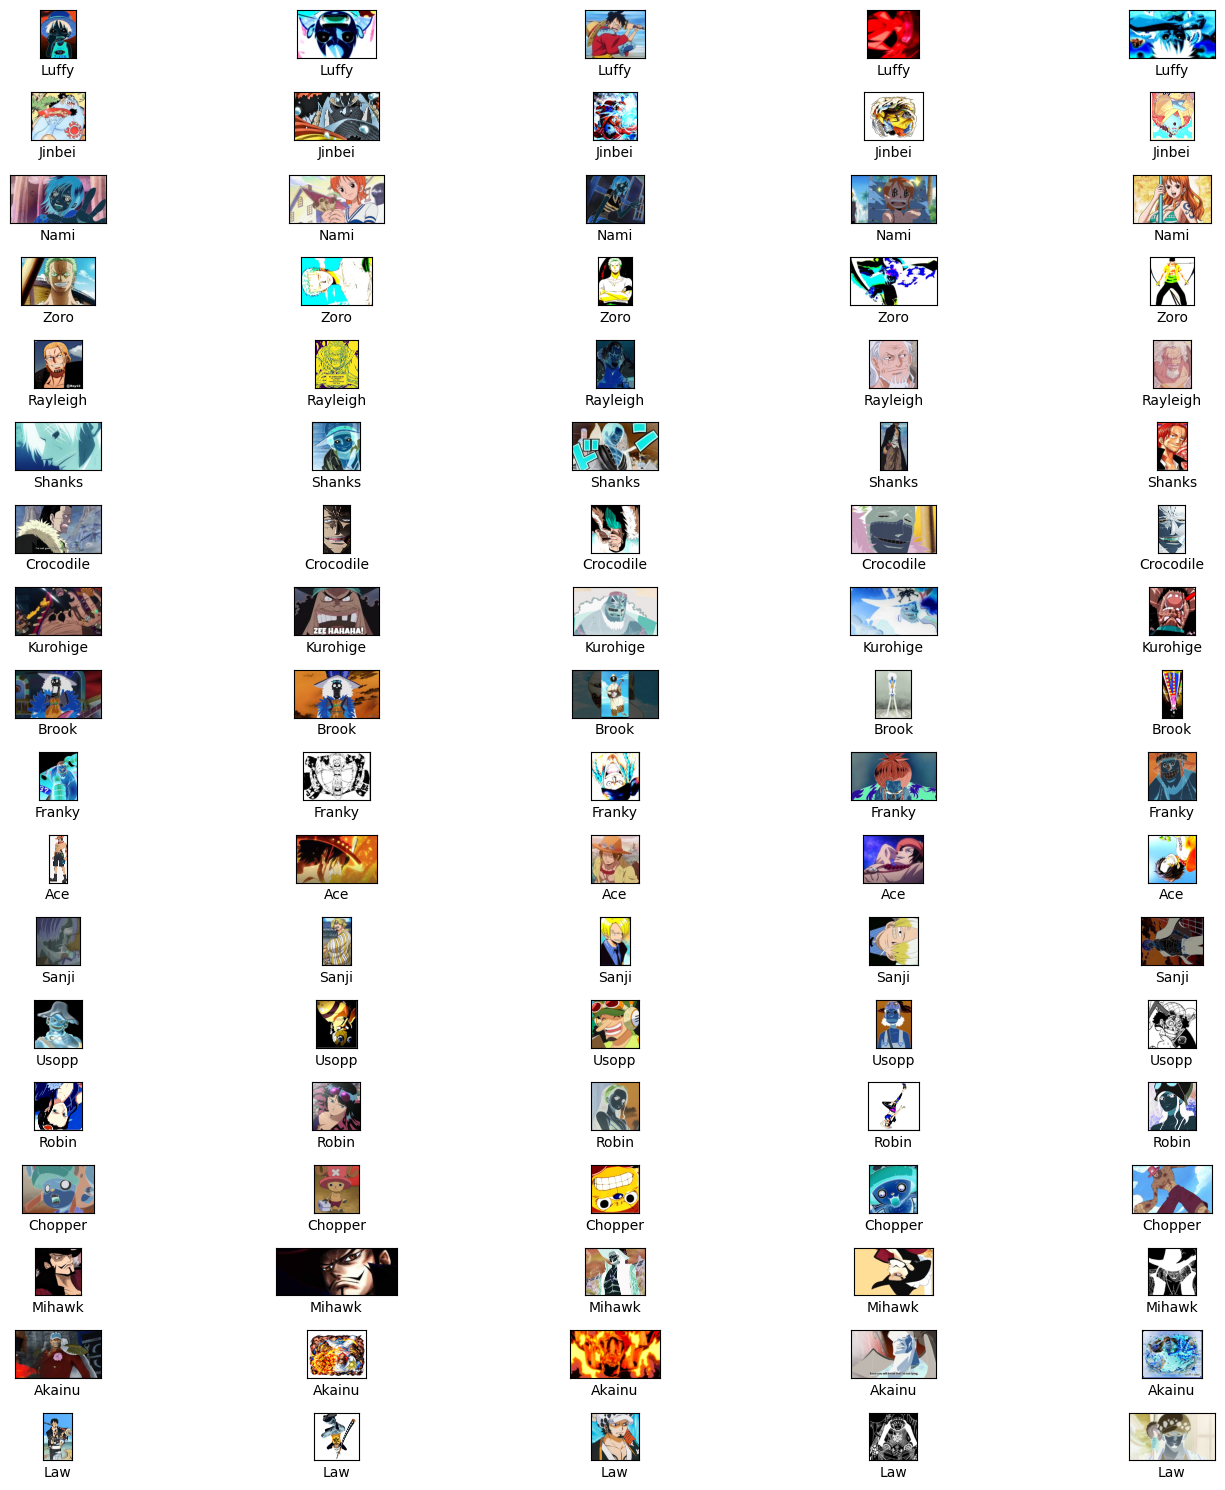

In [10]:
image = {}
path = "/content/Data/Data"
for i in os.listdir(path):
    image[i] = os.listdir(os.path.join(path, i))

fig, axs = plt.subplots(len(image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

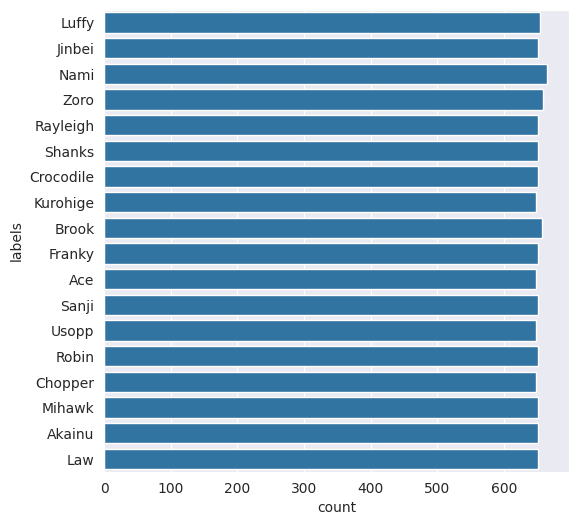

In [11]:
path_data = "/content/Data/Data"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(path_data):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [12]:
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return img

def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return img


def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy() if tf.is_tensor(img) else img
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return img

def sheared(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [13]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'flip up down': flip_up_down,
    'shear image': sheared
}

base_path = "/content/Data/Data"
aug_base_path = "/content/Data/Augmented"
images_to_generate = 650

labels_to_augment = [label for label in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, label))]

for label in labels_to_augment:
    images_path = os.path.join(base_path, label)
    augmented_path = os.path.join(aug_base_path, label)
    os.makedirs(augmented_path, exist_ok=True)

    images = [os.path.join(images_path, im) for im in os.listdir(images_path) if im.lower().endswith(('.jpg', '.jpeg', '.png'))]

    i = 1
    while i <= images_to_generate:
        image = random.choice(images)
        try:
            pil_image = Image.open(image).convert('RGB')
            original_image = np.array(pil_image)

            if original_image.ndim == 2:
                original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
            elif original_image.ndim == 3:
                  if original_image.shape[2] == 1:
                      original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
                  elif original_image.shape[2] == 4:
                        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2RGB)
                  elif original_image.shape[2] == 3:
                       pass
            else:
                raise ValueError(f"Unsupported number of channels: {original_image.shape[2]}")

            original_image = original_image.astype(np.float32) / 255.0
            transformed_image = original_image
            transformation_count = random.randint(1, len(transformations))

            for _ in range(transformation_count):
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)

            new_image_path = f"{augmented_path}/augmented_image_{i}.jpg"

            if tf.is_tensor(transformed_image):
                transformed_image = transformed_image.numpy()

            transformed_image = np.clip(transformed_image, 0, 1)
            transformed_image = (transformed_image * 255).astype(np.uint8)

            cv2.imwrite(new_image_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
            i += 1

        except Exception as e:
            print('Skipping:', image, '| Reason:', e)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [14]:
resize_base_paths = [
    "/content/Data/Data",
    "/content/Data/Augmented"
]

target_size = (224, 224)

for base_path in resize_base_paths:
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)

        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                try:
                    with Image.open(file_path) as img:
                        img = img.convert('RGB')
                        img_resized = img.resize(target_size)
                        img_resized.save(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

In [15]:
dataset_path = "/content/Data"

image_sizes = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                image_sizes.append(img.size)

for i, size in enumerate(image_sizes[:10]):
    print(f"Gambar ke-{i+1}: {size}")

from collections import Counter
size_distribution = Counter(image_sizes)

print("\nDistribusi ukuran gambar:")
for size, count in size_distribution.items():
    print(f"{size}: {count} gambar")

Gambar ke-1: (224, 224)
Gambar ke-2: (224, 224)
Gambar ke-3: (224, 224)
Gambar ke-4: (224, 224)
Gambar ke-5: (224, 224)
Gambar ke-6: (224, 224)
Gambar ke-7: (224, 224)
Gambar ke-8: (224, 224)
Gambar ke-9: (224, 224)
Gambar ke-10: (224, 224)

Distribusi ukuran gambar:
(224, 224): 23437 gambar


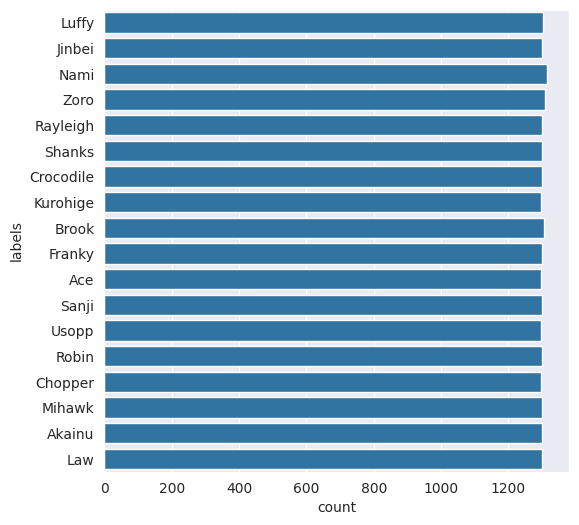

In [16]:
path_data = "/content/Data"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(path_data):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [17]:
mypath= '/content/Data'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
Ace,1298
Akainu,1301
Brook,1307
Chopper,1298
Crocodile,1301
Franky,1301
Jinbei,1301
Kurohige,1298
Law,1301


In [18]:
X= df['path']
y= df['labels']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=32, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=32, stratify=y_temp)

print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Train: 14062
Validation: 8437
Test: 938


Splitting data pada project ini dilakukan dengan skala 6:3:1 untuk training sebesar 60% dan validation sebesar 30% dan train sebesar 10%

In [19]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})

print('train size', len(df_tr))
print('test size', len(df_te))
print('validation size', len(df_val))

train size 14062
test size 938
validation size 8437


In [20]:
df_all = pd.concat([df_tr, df_te,df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))


set    labels   
test   Ace           52
       Akainu        52
       Brook         52
       Chopper       52
       Crocodile     52
       Franky        52
       Jinbei        52
       Kurohige      52
       Law           52
       Luffy         52
       Mihawk        52
       Nami          53
       Rayleigh      52
       Robin         52
       Sanji         52
       Shanks        52
       Usopp         52
       Zoro          53
train  Ace          779
       Akainu       781
       Brook        784
       Chopper      779
       Crocodile    781
       Franky       781
       Jinbei       780
       Kurohige     779
       Law          780
       Luffy        782
       Mihawk       781
       Nami         789
       Rayleigh     780
       Robin        781
       Sanji        780
       Shanks       781
       Usopp        779
       Zoro         785
val    Ace          467
       Akainu       468
       Brook        471
       Chopper      467
       Crocodile    46

In [21]:
datasource_path = "/content/Data"
dataset_path = "Final-Data/"

In [22]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

Hasil penggabungan dari dataset asli dan hasil augmentasi data tercatat ada sekitar 23437 data yang siap untuk di bagi pada proses splitting data

In [23]:
TRAIN_DIR = "Final-Data/train/"
TEST_DIR = "Final-Data/test/"
VAL_DIR = "Final-Data/val/"

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True
)


val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    batch_size=32,
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 14062 images belonging to 18 classes.
Found 8437 images belonging to 18 classes.
Found 938 images belonging to 18 classes.


## Modelling

# Model CNN with Transfer Learning MobileNetV2

In [31]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:100]:
        layer.trainable = False
for layer in base_model.layers[100:]:
        layer.trainable = True

model = Sequential([
    base_model,

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(18, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
# Custom Callback
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=0.95):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.threshold:
            print(f'\nValidation accuracy mencapai {val_acc:.4f} (target: {self.threshold:.4f})')
            print('Akurasi sudah tercapai')
            self.model.stop_training = True

accuracy_threshold = AccuracyThresholdCallback(threshold=0.95)
# Callback Early Stop
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Callback for reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

train_dir = 'Final-Data/train'
classes = os.listdir(train_dir)

y_train_labels = []
for label in classes:
    folder_path = os.path.join(train_dir, label)
    y_train_labels.extend([label] * len(os.listdir(folder_path)))

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_labels),
                                     y=y_train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

history_model_tl = model.fit(train_generator,
                        epochs=100,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks = [early_stopping, reduce_lr, accuracy_threshold],
                        class_weight = class_weights_dict
                        )

Epoch 1/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1276 - loss: 6.8435

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


440/440 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step - accuracy: 0.1277 - loss: 6.8424 - val_accuracy: 0.3685 - val_loss: 5.4307 - learning_rate: 5.0000e-05
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.3781 - loss: 5.3401 - val_accuracy: 0.5222 - val_loss: 4.7940 - learning_rate: 5.0000e-05
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 88s 115ms/step - accuracy: 0.5531 - loss: 4.6254 - val_accuracy: 0.6316 - val_loss: 4.2740 - learning_rate: 5.0000e-05
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.6660 - loss: 4.1064 - val_accuracy: 0.7213 - val_loss: 3.8518 - learning_rate: 5.0000e-05
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - accuracy: 0.7617 - loss: 3.6906 - val_accuracy: 0.7753 - val_loss: 3.5389 - learning_rate: 5.0000e-05
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - accuracy: 0.8233 - loss: 3.3478 - val_accuracy: 0.8213 - val_loss: 3.2397 - learning_rate: 5.0000e-05
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/s

In [33]:
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.batch_size
)

print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0184
Loss: 0.01841634325683117
Accuracy: 1.0


## Evaluasi dan Visualisasi

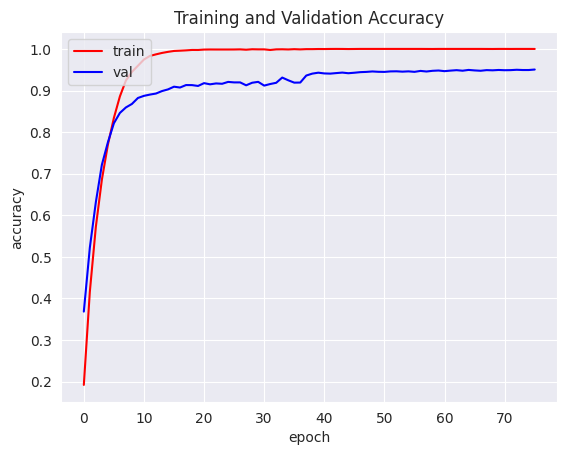

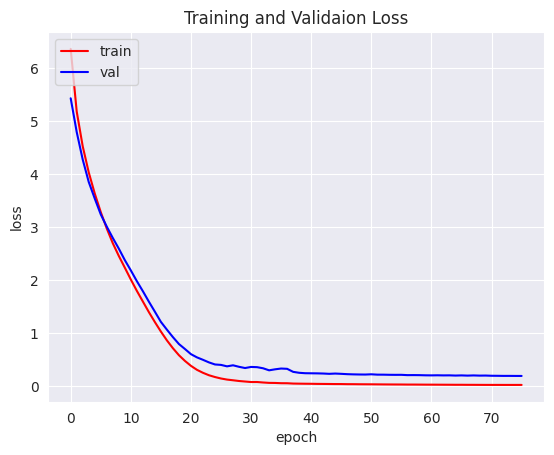

In [35]:
acc = history_model_tl.history['accuracy']
val_acc = history_model_tl.history['val_accuracy']
loss = history_model_tl.history['loss']
val_loss = history_model_tl.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## Konversi Model

In [38]:
save_path = '/content/mymodel/'
tf.saved_model.save(model, save_path)

In [39]:
!pip install tensorflowjs
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    /content/mymodel \
    /content/my_model_tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-20 07:18:47.714046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745133527.734615   23017 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [40]:
tflite_dir = 'tflite'
os.makedirs(tflite_dir, exist_ok=True)

class_names = df['labels'].unique()

saved_model_dir = save_path
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

tflite_model_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan ke {tflite_model_path}")

labels_path = os.path.join(tflite_dir, 'label.txt')
with open(labels_path, 'w') as f:
    for label in class_names:
        f.write(label + '\n')

print(f"Label file berhasil disimpan di {labels_path}")

Model berhasil dikonversi dan disimpan ke tflite/model.tflite
Label file berhasil disimpan di tflite/label.txt


## Inference (Optional)

FileUpload(value={}, accept='image/*', description='Upload')

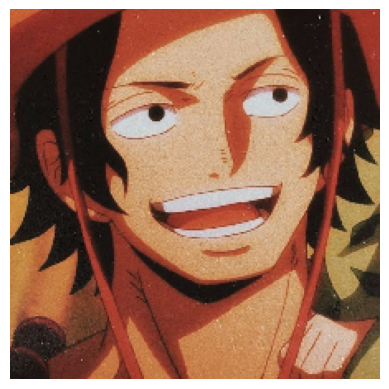

Prediksi: Ace


In [46]:
model = TFSMLayer('/content/mymodel', call_endpoint='serving_default')

class_names = list(validation_generator.class_indices.keys())

uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)


def on_upload_change(change):
    for name, file_info in uploader.value.items():
        img_bytes = file_info['content']
        img = image.load_img(io.BytesIO(img_bytes), target_size=(224, 224))

        plt.imshow(img)
        plt.axis('off')
        plt.show()

        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model(img_array)
        predicted_index = np.argmax(prediction)
        predicted_label = class_names[predicted_index]

        print(f'Prediksi: {predicted_label}')

uploader.observe(on_upload_change, names='value')